# MotoGP Regression Part 3 - Linear Regression Modeling
Ankur Vishwakarma  
Metis Winter 2018

<img src="http://css.motogp.com/w2015/img/logos/motogp.svg?version=a4b2faf82fe5880934375619ed3dac5aadb10ea007af6f4f770b682e0d16dbf6" width="120" align="left"/>

---
## Table of Contents  
1. [Initializing the Data](#import_clean)
    1. [Importing](#import)
    2. [Reformatting](#format)
    3. [Adding Data](#adding)
    4. [Check Data Significance](#significant)
2. [Dealing with Categoricals](#categoricals)
3. [Exploratory Data Analysis](#eda)
    1. [Target Distribution](#eda_dist)
    2. [Correlations](#eda_corr)
    3. [Seaborn Plots](#eda_sea)
4. [Modeling](#modeling)
    1. [Train/Test Split](#m_tra)
    2. [Baseline OLS](#m_ols)
    3. [Expanding the Model](#m_exp)
    4. [Cross Validation](#m_cval)
    5. [Lasso Regularization](#m_reg)
    6. [Polynomial Terms](#m_pol)
5. [Conclusion](#con)
---

### 1. Initializing the Data <a name = 'import_clean'></a>  
#### Importing <a name='import'></a>
We'll try to explore if it's possible to estimate the race finish time using weather data, track characteristics, and team type (MotoGP, Moto2, etc.). First, we start by importing the master dataframe and cleaning it up.

In [553]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [7]:
# read in the MotoGP_2005_2017.csv file
df_orig = pd.read_csv('MotoGP_2005_2017.csv', index_col=0, parse_dates=['Date'])

In [8]:
# examine the first row
df_orig.head(1)

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,GP,track_length_km,l_corners,r_corners,width_m,straight_m,GP_avg_speed,gp_dist,m2_dist,m3_dist
0,2017,QAT,Grand Prix of Qatar - Losail International Cir...,MotoGP,RAC,2017-03-26,Dry,22.0,21.0,0.96,...,QAT - Losail International Circuit,5.4,6,10,12.0,1068.0,165.5,118.4,107.6,96.8


#### Reformatting <a name='format'></a>

In [9]:
# check how the columns are formatted
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19412 entries, 0 to 19411
Data columns (total 30 columns):
Year               19412 non-null int64
TRK                19412 non-null object
Track              19412 non-null object
Category           19412 non-null object
Session            19412 non-null object
Date               19410 non-null datetime64[ns]
Track_Condition    19328 non-null object
Track_Temp         19328 non-null float64
Air_Temp           19328 non-null float64
Humidity           19328 non-null float64
Position           19410 non-null object
Points             19410 non-null float64
Rider_Number       19328 non-null float64
Rider_Name         19410 non-null object
Nationality        19410 non-null object
Team_Name          19328 non-null object
Bike               19410 non-null object
Avg_Speed          18711 non-null float64
Time               19409 non-null object
Finish_Time        14566 non-null object
GP                 19412 non-null object
track_length_km  

There are several issues here. The 'Finish_Time' column is formatted as an object, for example. We will also need to get rid of a lot of categorical data eventually. Therefore, we'll create a new dataframe to work off of. 

In [222]:
df = df_orig.copy(deep=True)

In [223]:
# convert finish time into a numerical since it'll be the target of our regression
df['Finish_Time'] = df['Finish_Time'].map(lambda x: pd.to_timedelta(x))
df['Finish_Time_ms'] = df['Finish_Time'].map(lambda x: x/pd.to_timedelta(1, unit='ms'))

# add up left and right corners
df['corners'] = df['l_corners'] + df['r_corners']

# drop N/A values
df.dropna(axis = 0, inplace=True)

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11864 entries, 0 to 19398
Data columns (total 32 columns):
Year               11864 non-null int64
TRK                11864 non-null object
Track              11864 non-null object
Category           11864 non-null object
Session            11864 non-null object
Date               11864 non-null datetime64[ns]
Track_Condition    11864 non-null object
Track_Temp         11864 non-null float64
Air_Temp           11864 non-null float64
Humidity           11864 non-null float64
Position           11864 non-null object
Points             11864 non-null float64
Rider_Number       11864 non-null float64
Rider_Name         11864 non-null object
Nationality        11864 non-null object
Team_Name          11864 non-null object
Bike               11864 non-null object
Avg_Speed          11864 non-null float64
Time               11864 non-null object
Finish_Time        11864 non-null timedelta64[ns]
GP                 11864 non-null object
track_le

Looks better! One column we are going to add at this point is mean_points - that'll contain the mean points earned by a rider throughout their racing career between 2005 and 2017. The better a rider finishes a race, the more points they earn. Theoretically, better riders should have higher mean points per race. This should put in an element of the rider's skill in predicting our race finish times.

#### Adding Data <a name='adding'></a>

In [227]:
# examine the top 20 riders
(df
 .groupby(['Rider_Name'])['Points']
 .mean().reset_index()
 .sort_values(by='Points', ascending=False)
).head(20)

,Rider_Name,Points
80,Daniel PEDROSA,22.800000
280,Marc MARQUEZ,18.896552
202,Jorge LORENZO,17.942308
66,Casey STONER,17.937500
444,Valentino ROSSI,16.534591
76,Dani PEDROSA,16.121429
187,Joan MIR,15.066667
300,Maverick VIÑALES,14.285714
22,Alex RINS,13.168675
31,Andrea DOVIZIOSO,12.874214


There is clearly a mistake up there with the rider having the highest mean points per race. **Daniel PEDROSA** is the same person as **Dani PEDROSA**. Turns out he raced under his full name in year 2005. Let's fix that so his mean points value is correct.

In [255]:
df.replace(to_replace='Daniel PEDROSA', value='Dani PEDROSA', inplace=True)
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
279,Marc MARQUEZ,18.896552
201,Jorge LORENZO,17.942308
66,Casey STONER,17.937500
76,Dani PEDROSA,16.566667
443,Valentino ROSSI,16.534591
186,Joan MIR,15.066667
299,Maverick VIÑALES,14.285714
22,Alex RINS,13.168675
31,Andrea DOVIZIOSO,12.874214
426,Thomas LUTHI,12.457516


*That's better.*  

Now, we add it back to the main dataframe.

In [256]:
df = df.merge(df_rider_mean, on='Rider_Name', how='left')

#### Check Data Signifiance <a name='significant'></a>

In [257]:
df.describe()

,Year,Track_Temp,Air_Temp,Humidity,Points,Rider_Number,Avg_Speed,Finish_Time,track_length_km,l_corners,r_corners,width_m,straight_m,GP_avg_speed,gp_dist,m2_dist,m3_dist,Finish_Time_ms,corners,points_mean
count,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,11864.000000,1.186400e+04,11864.000000,11864.000000
mean,2011.764076,29.862272,21.798550,0.508727,6.438638,38.736598,152.628978,0 days 00:40:14.415056,4.763545,6.738874,8.174646,13.682991,805.701028,161.634634,117.403742,108.761253,99.891268,2.414415e+06,14.913520,6.438638
std,3.686078,9.016675,5.275616,0.213710,6.985301,27.333769,9.898253,0 days 00:06:53.763804,0.615363,1.823980,2.321648,1.461545,206.833388,10.426850,3.109882,2.414168,2.564184,4.137638e+05,1.985008,4.584040
min,2005.000000,10.000000,11.000000,0.100000,0.000000,1.000000,114.800000,0 days 00:05:04.623000,3.700000,3.000000,3.000000,11.000000,487.000000,140.000000,110.100000,104.700000,96.000000,3.046230e+05,10.000000,0.000000
25%,2009.000000,23.000000,18.000000,0.360000,0.000000,15.000000,146.000000,0 days 00:39:51.172000,4.200000,6.000000,7.000000,12.000000,636.000000,156.200000,116.800000,106.600000,97.200000,2.391172e+06,14.000000,2.561905
50%,2012.000000,29.000000,21.000000,0.500000,5.000000,35.000000,152.500000,0 days 00:41:30.816000,4.800000,6.000000,9.000000,14.000000,770.000000,161.100000,118.300000,108.800000,99.900000,2.490816e+06,14.000000,6.179487
75%,2015.000000,36.000000,25.000000,0.650000,10.000000,58.000000,158.900000,0 days 00:43:28.837250,5.400000,8.000000,10.000000,15.000000,968.000000,169.900000,119.400000,110.100000,101.700000,2.608837e+06,16.000000,9.202899
max,2017.000000,55.000000,41.000000,0.990000,25.000000,99.000000,182.600000,0 days 00:53:12.157000,5.900000,11.000000,12.000000,16.000000,1200.000000,182.600000,120.900000,115.000000,104.900000,3.192157e+06,20.000000,18.896552


Most of the datapoints look good. Furthermore, they are meaningful - they are within the range that's expected and free of 'n/a' values. The one that stands out as odd is the spread on the 'Finish_Time'. The minimum value is 5 minutes and 4 seconds - way too short to be an actual race. Looks like some of the datapoints in this dataframe include races that were cut short or cancelled. We'll investigate this further in a bit with a histogram of the target to see its distribution.

### 2. Dealing with Categoricals <a name = 'categoricals'></a>

Many columns in the full dataframe above, such as 'Rider_Name', 'Team_Name', etc. are strings that are ultimately not relevant to the regression modeling. In the next step, we remove most of them and then get dummy variables for the remaining strings that are relevant, such as whether the track is wet or dry. 

In [608]:
# get rid of string columns that we do not need to keep for linear regression
# the 'c' in 'df_c' stands for 'category' since that's a string column we've kept
df_c = df.drop(axis=1, columns=['TRK', 'Track', 'Session', 'Date', 'Position', 'Rider_Name',
                                'Rider_Number', 'Nationality', 'Team_Name', 'Time', 'Finish_Time',
                                'GP', 'l_corners', 'r_corners', 'Bike', 'Avg_Speed'])

In [613]:
df_c = pd.get_dummies(df_c)
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11864 entries, 0 to 11863
Data columns (total 23 columns):
Year                       11864 non-null int64
Track_Temp                 11864 non-null float64
Air_Temp                   11864 non-null float64
Humidity                   11864 non-null float64
Points                     11864 non-null float64
track_length_km            11864 non-null float64
width_m                    11864 non-null float64
straight_m                 11864 non-null float64
GP_avg_speed               11864 non-null float64
gp_dist                    11864 non-null float64
m2_dist                    11864 non-null float64
m3_dist                    11864 non-null float64
Finish_Time_ms             11864 non-null float64
corners                    11864 non-null int64
points_mean                11864 non-null float64
Category_125cc             11864 non-null uint8
Category_250cc             11864 non-null uint8
Category_Moto2             11864 non-null uint8
C

### 3. Exploratory Data Analysis <a name ='eda'></a>
#### Target Distribution <a name = 'eda_dist'></a>

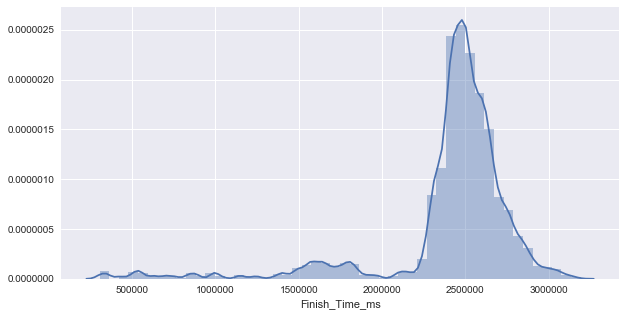

In [614]:
# distribution of target (race finish times in milliseconds)
plt.figure(figsize=(10,5))
sns.distplot(df_c.Finish_Time_ms);

Our target distribution is very left skewed. The values far on the left most likely represent race finish times in special cases, such as a race cut short by weather, accidents, mechanical issues, etc. Let's diagnose how many races are so short and why.

In [615]:
threshold = 2000000 # in milliseconds
print('All rows:', len(df_c))
print('Rows over threshold:',len(df_c[df_c.Finish_Time_ms >= threshold]))
print('Data kept:','{0:0.2%}'.format(len(df_c[df_c.Finish_Time_ms >= threshold])/len(df_c)))

All rows: 11864
Rows over threshold: 10672
Data kept: 89.95%


Good news - 90% of our data is over the 2,000,000 milliseconds (33 minutes, 20 seconds). Let's check that our assumption that these are not full-length races are true.

In [368]:
# df[(df.Finish_Time_ms <= threshold)].sample(5)
# code is commented out so not to rewrite the sample generated below

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,r_corners,width_m,straight_m,GP_avg_speed,gp_dist,m2_dist,m3_dist,Finish_Time_ms,corners,points_mean
4748,2013,AME,Red Bull Grand Prix of The Americas - Circuit ...,Moto3,RAC,2013-04-21,Dry,27.0,19.0,0.62,...,9,15.0,1200.0,157.9,115.8,104.7,99.2,1438778.0,20,7.126984
1041,2017,AUS,Michelin® Australian Motorcycle Grand Prix - P...,Moto3,RAC,2017-10-22,Dry,24.0,15.0,0.83,...,5,13.0,900.0,176.4,120.1,111.2,102.3,1516783.0,12,1.142857
3210,2015,JPN,Motul Grand Prix of Japan - Twin Ring Motegi,Moto2,RAC,2015-10-11,Wet,21.0,19.0,0.95,...,8,15.0,762.0,146.3,115.2,110.4,96.0,1900758.0,14,5.062500
568,2017,CZE,Monster Energy Grand Prix České republiky - Au...,Moto2,RAC,2017-08-06,Dry,22.0,20.0,0.80,...,8,15.0,636.0,161.1,118.9,108.1,102.7,874782.0,14,11.551724
9180,2008,FRA,FRENCH GRAND PRIX - Le Mans,125cc,RAC,2008-05-18,Dry,21.0,15.0,0.42,...,9,13.0,674.0,161.6,117.2,108.8,100.4,1485145.0,14,7.677852


* **2013 - Moto3 @ Circuit of the Americas:** "The Moto3 race was stopped after ten laps and restarted over a distance of five laps." ([Link](https://en.wikipedia.org/wiki/2013_Motorcycle_Grand_Prix_of_the_Americas#ref_1))
* **2017 - Moto3 @ Australia:** "There were spots of rain from time to time as the race went on, until a sudden downpour greeted the riders as they crossed the line to start lap 17. The leading pack all sat up holding their hands in the air, and the race was red flagged." ([Link](https://www.asphaltandrubber.com/motogp/sunday-australian-gp-motogp-summary-2017/))
* **2015 - Moto2 @ Japan:** "Due to weather conditions which caused delays in the schedule, the race distance was reduced from 23 to 15 laps." ([Link](https://en.wikipedia.org/wiki/2015_Japanese_motorcycle_Grand_Prix#cite_note-dist-10))
* **2017 - Moto2 @ Czech Republic:** "The race, scheduled to be run for 20 laps, was red-flagged on lap 8 due to changing track conditions. The race was later restarted over 6 laps." ([Link](https://en.wikipedia.org/wiki/2017_Czech_Republic_motorcycle_Grand_Prix#Moto2))
* **2008 - 125cc @ France:** "The race was stopped after 14 laps due to rain. It was later restarted for 5 additional laps, with the grid determined by the running order before the suspension. The second part of the race determined the final result." ([Link](https://en.wikipedia.org/wiki/2008_French_motorcycle_Grand_Prix#125_cc_classification))  

Of the 5 races above that reportedly took less than 30 minutes, all 5 of them were special cases where the race had been shortened due to an accident or weather conditions. We can now confidently remove these outliers from the dataset.

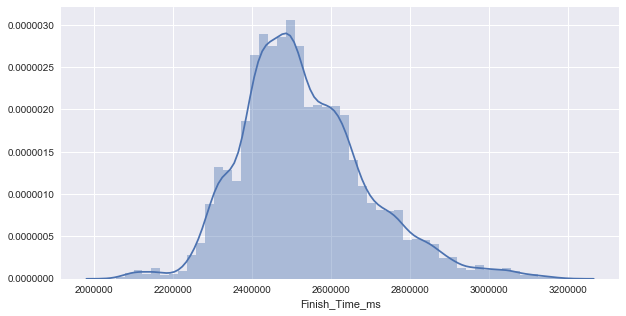

In [616]:
df_c_normal = df_c[df_c.Finish_Time_ms >= threshold]
plt.figure(figsize=(10,5))
sns.distplot(df_c_normal.Finish_Time_ms);

In [930]:
36908/df_c_normal.Finish_Time_ms.mean()

0.014575974826674139

#### Correlations <a name='eda_corr'></a>

The heatmap below shows the correlations between the features in this dataset. While there are some expected results, such as strong correlation between air temperature and track temperature, we also see some sensible relations that should be useful in generating a good model:
* Finishing time is moderately correlated with the category of racing and track conditions. 
* Number of corners is correlated with the total length of track.
* Finishing time is also correlated with 'GP_avg_speed' - a track category useful for racetracks where MotoGP has raced previously but not so useful when we don't have that date, like for a brand new racetrack.

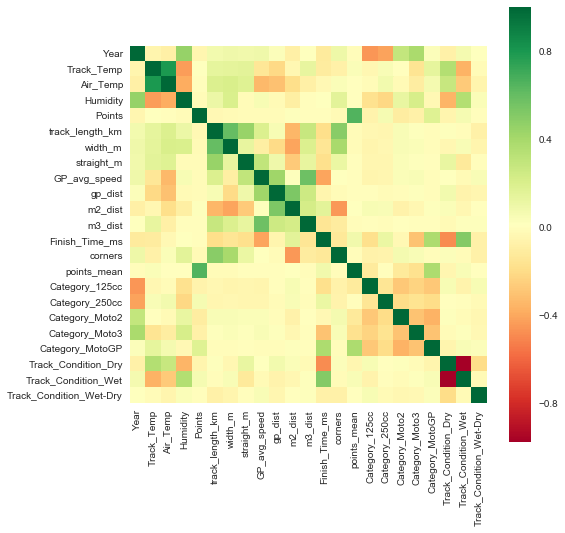

In [617]:
plt.figure(figsize=(8,8))
sns.heatmap(df_c_normal.corr(), square=True, cmap='RdYlGn');

#### Seaborn Plots <a name='eda_sea'></a>
Let's examine the pairplot for Finish_Time_ms against the other variables.

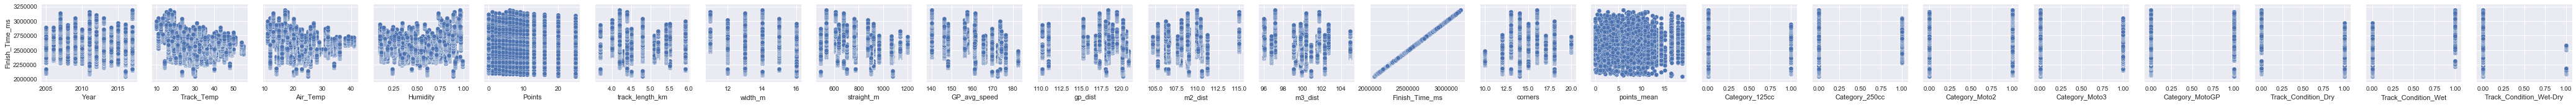

In [324]:
sns.pairplot(data=df_c_normal,
                  y_vars=['Finish_Time_ms'],
                  x_vars=df_c_normal.columns);

Unfortunately, no variables stand out as linearly correlated with our target, the finishing time. 
1. There might be some trends against the temperature and humidity variables, the straight_m (longest straight), etc.
2. The categoricals all the way on the right should help too as their distributions show that the mean values for a 0 or 1 do look different. 
3. Finally, it's not clear if there is any relation with 'points_mean' which is the one variable we have that loosely indicates a rider's skill.

### 4. Modeling <a name='modeling'></a>

#### Train/Test Split <a name='m_tra'></a>

In [880]:
from sklearn.model_selection import train_test_split

df_lm = df_c_normal
print(df_lm.columns)

x_all = df_lm.loc[:,['track_length_km', 'Track_Temp', 'Track_Condition_Dry', 'Track_Condition_Wet', 
                     'Track_Condition_Wet-Dry', 'Category_MotoGP', 'Category_Moto3']]

y_all = df_lm['Finish_Time_ms']

# hold out 20% for final testing
x, x_ho, y, y_ho = train_test_split(x_all, y_all, test_size=.2, random_state=0)

Index(['Year', 'Track_Temp', 'Air_Temp', 'Humidity', 'Points',
       'track_length_km', 'width_m', 'straight_m', 'GP_avg_speed', 'gp_dist',
       'm2_dist', 'm3_dist', 'Finish_Time_ms', 'corners', 'points_mean',
       'Category_125cc', 'Category_250cc', 'Category_Moto2', 'Category_Moto3',
       'Category_MotoGP', 'Track_Condition_Dry', 'Track_Condition_Wet',
       'Track_Condition_Wet-Dry'],
      dtype='object')


> Note: When I first did this, I included the "GP Average Speed" and "Points" variables, which could be lag variables and resulted in a final R<sup>2</sup> of 0.97 with a 3-degree polynomial regression. Those variables are removed from the following code blocks to see how the model works without them.

#### Baseline OLS  <a name ='m_ols'></a>  
Since we can't see any obvious trends from the seaborn plots above, we'll build a simple linear regression model using ordinary least squares (OLS) and see how it performs with various features on the training data. Here are the features we try:  
1. (R<sup>2</sup>) - Variables
2. (0.035) - Track length
3. (0.037) - Track length & # of corners
4. (0.042) - Track length & Track Temp
5. (0.041) - Track length, Track Temp, & Humidity  
6. (0.279) - Track length, Track Temp, & Condition_Dry
7. (0.312) - Track length, Track Temp, Condition_Dry, & Condition_Wet
8. (0.312) - Track length, Track Temp, Condition_Dry, Condition_Wet, & Condition_Wet-Dry
9. (0.426) - Track length, Track Temp, Condition_Dry, Condition_Wet, & Category_MotoGP
10. (0.471) - Track length, Track Temp, Condition_Dry, Condition_Wet, Category_MotoGP, & Category_Moto3

In [881]:
model = sm.OLS(y,sm.add_constant(x))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Finish_Time_ms   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1269.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:16:24   Log-Likelihood:            -1.1180e+05
No. Observations:                8537   AIC:                         2.236e+05
Df Residuals:                    8530   BIC:                         2.237e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2.049e+06   8975.340    228.270      0.000    2.03e+06    2.07e+06
track_length_km          -4.84e+04   2083.477    -23.232      0.000   -5.25e+04   -4.43e+04
Track_Temp                412.9095    155.871      2.649      0.008     107.365     718.454
Track_Condition_Dry      6.666e+05   6199.465    107.530      0.000    6.54e+05    6.79e+05
Track_Condition_Wet      9.453e+05   6647.224    142.210      0.000    9.32e+05    9.58e+05
Track_Condition_Wet-Dry  4.369e+05   1.55e+04     28.131      0.000    4.06e+05    4.67e+05
Category_MotoGP          1.031e+05   3069.672     33.572      0.000     9.7e+04    1.09e+05
Category_Moto3          -9.146e+04   3369.186    -27.146      0.000   -9.81e+04   -8.49e+04
==============================================================================
Omnibus:                      364.703   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              711.928
Skew:                          -0.316   Prob(JB):                    2.55e-155
Kurtosis:                       4.265   Cond. No.                     3.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Let's look at the residuals.

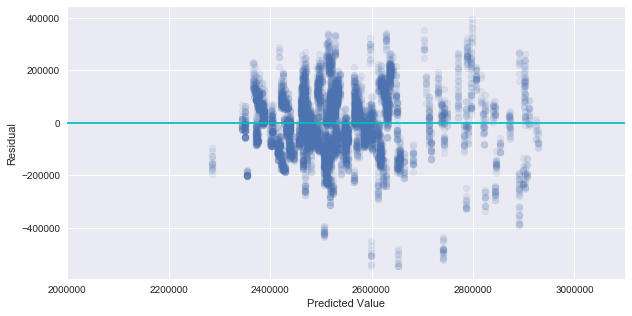

In [882]:
y_pred = results.predict(sm.add_constant(x))

plt.figure(figsize=(10,5))
plt.xlim(xmin=2000000, xmax=3100000)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.scatter(y_pred,y-y_pred,alpha=.1);
plt.plot(np.linspace(0,3100000,1000),np.linspace(0,0,1000), color='c');

#### Expanding the model <a name='m_exp'></a>

In [909]:
# let's run OLS with all features

x_all = df_lm.loc[:,['Year', 'Track_Temp', 'Air_Temp', 'Humidity', 
                'track_length_km', 'width_m', 'straight_m',  'gp_dist',
                'm2_dist', 'm3_dist', 'corners', 'Category_125cc', 'points_mean',
                'Category_250cc', 'Category_Moto2', 'Category_Moto3', 'Category_MotoGP',
                'Track_Condition_Dry', 'Track_Condition_Wet',
                'Track_Condition_Wet-Dry']]

y_all = df_lm['Finish_Time_ms']

x, x_ho, y, y_ho = train_test_split(x_all, y_all, test_size=.2, random_state=0)

model = sm.OLS(y,sm.add_constant(x))
results = model.fit()
results.rsquared

0.57143728497369417

An R<sup>2</sup> value of 0.571 is definitely better than our last iteration of 0.471. Perhaps there is value in keeping all the features. Let's see if we can remove a few variables while maintaining this R<sup>2</sup> value and then look at the residuals. 

Specifically, we'll try to remove features that correlate with each other, like air temperature & track temperature. 

In [910]:
x_all = df_lm.loc[:,['Year', 'Track_Temp', 'Humidity',  'width_m', 'straight_m',
                     'gp_dist','m3_dist',  'Category_125cc', 'points_mean', 
                     'Category_Moto2', 'Category_Moto3', 'Category_MotoGP', 'Track_Condition_Dry', 
                     'Track_Condition_Wet']]

y_all = df_lm['Finish_Time_ms']

x, x_ho, y, y_ho = train_test_split(x_all, y_all, test_size=.2, random_state=0)

model = sm.OLS(y,sm.add_constant(x))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Finish_Time_ms   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     701.3
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        16:41:12   Log-Likelihood:            -1.1125e+05
No. Observations:                8537   AIC:                         2.225e+05
Df Residuals:                    8522   BIC:                         2.226e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.058e+07   1.01e+06     10.484      0.000     8.6e+06    1.26e+07
Year                -3560.9323    503.548     -7.072      0.000   -4548.009   -2573.856
Track_Temp            177.6901    172.263      1.032      0.302    -159.986     515.367
Humidity            -4.988e+04   7749.229     -6.436      0.000   -6.51e+04   -3.47e+04
width_m             -1.368e+04    907.618    -15.071      0.000   -1.55e+04   -1.19e+04
straight_m            -61.5010      6.029    -10.202      0.000     -73.318     -49.684
gp_dist              -183.3576    439.667     -0.417      0.677   -1045.211     678.496
m3_dist             -7472.0925    509.696    -14.660      0.000   -8471.221   -6472.964
Category_125cc      -1.064e+05   4976.136    -21.379      0.000   -1.16e+05   -9.66e+04
points_mean         -4115.8171    282.294    -14.580      0.000   -4669.182   -3562.452
Category_Moto2      -3.273e+04   5590.048     -5.855      0.000   -4.37e+04   -2.18e+04
Category_Moto3      -1.259e+05   6074.946    -20.728      0.000   -1.38e+05   -1.14e+05
Category_MotoGP       7.25e+04   5249.935     13.810      0.000    6.22e+04    8.28e+04
Track_Condition_Dry  1.697e+05   1.95e+04      8.688      0.000    1.31e+05    2.08e+05
Track_Condition_Wet  4.582e+05   1.98e+04     23.112      0.000    4.19e+05    4.97e+05
==============================================================================
Omnibus:                      607.772   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1313.548
Skew:                          -0.468   Prob(JB):                    5.84e-286
Kurtosis:                       4.679   Cond. No.                     1.83e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

>> Mean of residuals:  1.5130473604746302e-08


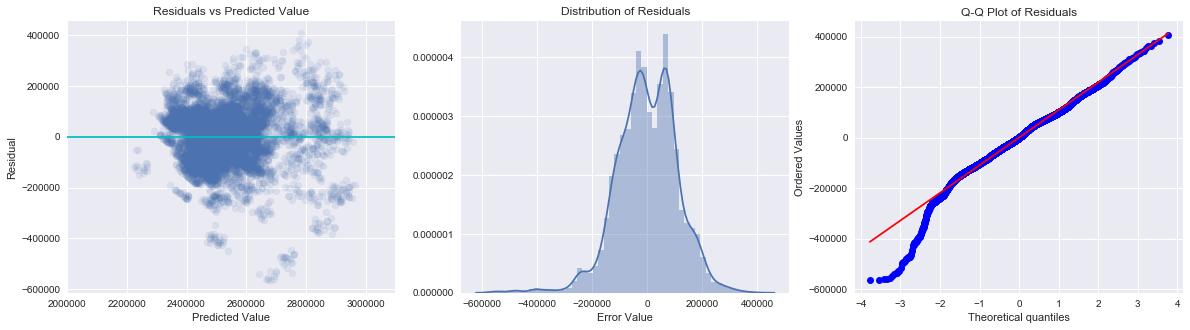

In [911]:
y_pred = results.predict(sm.add_constant(x))
res = y - y_pred

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Residuals vs Predicted Value')
plt.xlim(xmin=2000000, xmax=3100000)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.scatter(y_pred, res, alpha=.1);
plt.plot(np.linspace(0,3100000,1000),np.linspace(0,0,1000), color='c');

plt.subplot(1, 3, 2)
plt.title('Distribution of Residuals')
plt.xlabel('Error Value')
sns.distplot(res);

plt.subplot(1, 3, 3)
stats.probplot(res, plot=plt);
plt.title('Q-Q Plot of Residuals');

print('>> Mean of residuals: ',(res).mean())

1. The mean is close to zero.
2. On the left, the residuals seem to show slight fanning out for larger predictions (slight heteroskedacity), but otherwise, they don't look too bad.  It also seems that we have larger negative errors (model is predicting a larger value for certain inputs).
3. The middle plot shows that the distribution is indeed left-skewed, but is relatively normal. 
4. The Q-Q plot shows that the distribution of errors is not normal past 2 standard deviations. We have more error in one of the extremes than would be expected if they were distributed normally. In the next sections, we'll see how that's affected by regularization or adding polynomial terms.

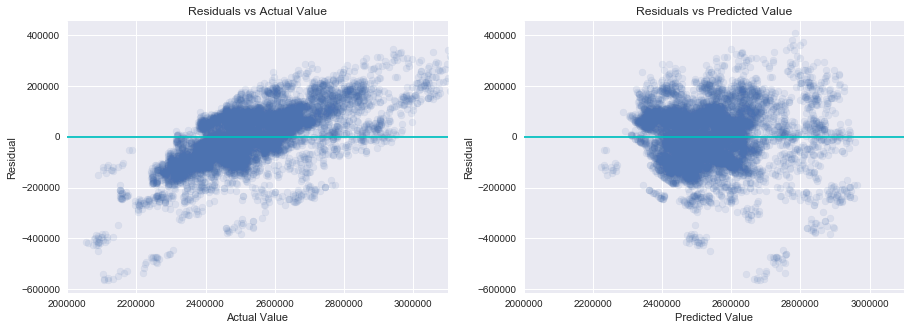

In [912]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Residuals vs Actual Value')
plt.xlabel('Actual Value')
plt.ylabel('Residual')
plt.xlim(xmin=2000000, xmax=3100000)
plt.scatter(y, res, alpha=0.1);
plt.plot(np.linspace(0,3100000,1000),np.linspace(0,0,1000), color='c');

plt.subplot(1, 2, 2)
plt.title('Residuals vs Predicted Value')
plt.xlim(xmin=2000000, xmax=3100000)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.scatter(y_pred, res, alpha=.1);
plt.plot(np.linspace(0,3100000,1000),np.linspace(0,0,1000), color='c');

#### Cross Validation <a name='m_cval'></a>

In [933]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=0)
pred_R2s = []
pred_RMSEs = []

for train_i, test_i in kf.split(x, y):
    
    lm = LinearRegression()
    lm.fit(x.iloc[train_i], y.iloc[train_i])
    y_pred = lm.predict(x.iloc[test_i])
    pred_R2s.append(lm.score(x.iloc[test_i], y.iloc[test_i]))
    pred_RMSEs.append(np.sqrt(np.mean((y_pred - y.iloc[test_i])**2)))

In [934]:
print('On test data')
print('------------------------------')
print('Mean R-squared:', np.mean(pred_R2s))
print('Mean RMSE:', np.mean(pred_RMSEs))

On test data
------------------------------
Mean R-squared: 0.533385382691
Mean RMSE: 110698.221918


That's good - cross-validation shows that our model performs just as well on validation data as it does on training data. Let's see if it improves by adding Lasso regularization.

#### Lasso Regularization <a name='m_reg'></a>

In [915]:
# scale it all first
from sklearn.preprocessing import StandardScaler
    
std = StandardScaler()
std.fit(x)
x_s = std.transform(x)
    
alphalist = 10**(np.linspace(-2,2,50))
alpha_R2s = np.zeros(len(alphalist))
alpha_RMSEs = np.zeros(len(alphalist))

for i, a in enumerate(alphalist):
    R2_kfold = []
    err_kfold = []
    
    for train_i, test_i in kf.split(x_s, y):

        ls = Lasso(alpha=a)
        ls.fit(x_s[train_i], y.iloc[train_i])
        y_pred_a = ls.predict(x_s[test_i])

        R2_kfold.append(ls.score(x_s[test_i], y.iloc[test_i]))
        err_kfold.append(np.sqrt(np.mean((y_pred_a - y.iloc[test_i])**2)))
    
    alpha_R2s[i] = np.mean(R2_kfold)
    alpha_RMSEs[i] = np.sum(err_kfold)

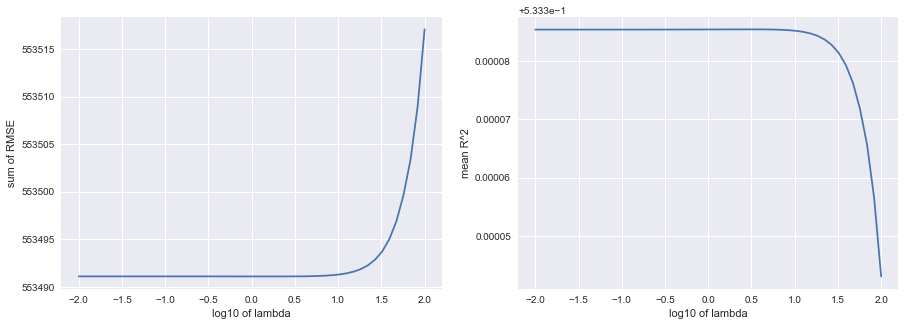

In [916]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.xlabel('log10 of lambda')
plt.ylabel('sum of RMSE')
plt.plot(np.log10(alphalist),alpha_RMSEs);

plt.subplot(1, 2, 2)
plt.xlabel('log10 of lambda')
plt.ylabel('mean R^2')
plt.plot(np.log10(alphalist),alpha_R2s);

In [917]:
print('With Lasso Regularization, on validation data')
print('------------------------------')
print('Mean R-squared:', np.mean(alpha_R2s))
print('Mean RMSE:', np.mean(alpha_RMSEs/5))

With Lasso Regularization, on validation data
------------------------------
Mean R-squared: 0.533382780072
Mean RMSE: 110698.549032


Neither our R<sup>2</sup> or RMSE values changed too much. With this particular dataset then, regularization does not have a huge impact. Not shown in this code, but Ridge regularization returned similar results.

#### Polynomial Terms <a name='m_pol'></a>  
Since we can't improve further than R<sup>2</sup> = 0.53 by using only linear functions of the predictor variables, let's try polynomial regression. After a few tries, a polynomial of degree 3 was determined to be the best predictor while also being computationally lightweight.

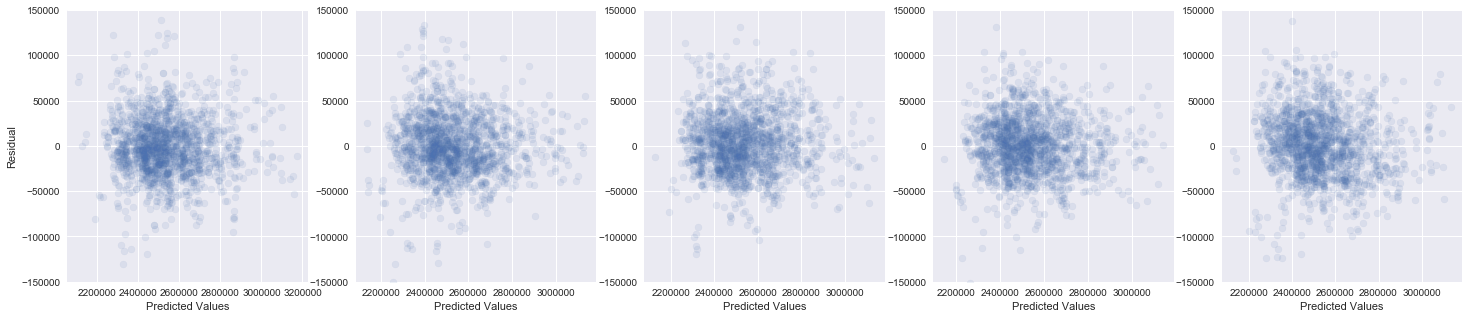

In [925]:
from sklearn.preprocessing import PolynomialFeatures

interactions = PolynomialFeatures(degree=3)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
pred_R2s = []
pred_RMSEs = []
i = 1

plt.figure(figsize=(25,5))
for train_i, test_i in kf.split(x, y):
    
    lm = LinearRegression()
    lm.fit(interactions.fit_transform(x.iloc[train_i]), y.iloc[train_i])
    y_pred = lm.predict(interactions.fit_transform(x.iloc[test_i]))
    
    plt.subplot(1, 5, i)
    plt.ylim(ymin = -150000, ymax=150000)
    if i == 1:
        plt.ylabel('Residual')
    plt.xlabel('Predicted Values')
    plt.scatter(y_pred, y.iloc[test_i]-y_pred, alpha=0.1);
    i += 1
    
    pred_R2s.append(lm.score(interactions.fit_transform(x.iloc[test_i]), y.iloc[test_i]))
    pred_RMSEs.append(np.sqrt(np.mean((y_pred - y.iloc[test_i])**2)))

Above are 5 charts for residuals vs predicted values, one for each kfold. They show that for each test case, our model's errors are randomly distributed. We can accept this result. 

In [926]:
print('On VALIDATION data')
print('------------------------------')
print('Mean R-squared:', np.mean(pred_R2s))
print('Mean RMSE:', np.mean(pred_RMSEs))

On VALIDATION data
------------------------------
Mean R-squared: 0.955118581446
Mean RMSE: 34299.3820751


In [927]:
print('On TEST data')
print('------------------------------')
print('Mean R-squared:', lm.score(interactions.fit_transform(x_ho), y_ho))
print('Mean RMSE:', np.sqrt(np.mean(((lm.predict(interactions.fit_transform(x_ho)) - y_ho)**2))))

On TEST data
------------------------------
Mean R-squared: 0.948652733213
Mean RMSE: 36908.4590636


That is not a bad result at all. Clearly this dataset could not be predicted as accurately with a simple regression of degree 1 polynomials only, as we tried earlier. 

>> Mean of residuals:  376.2838437225556


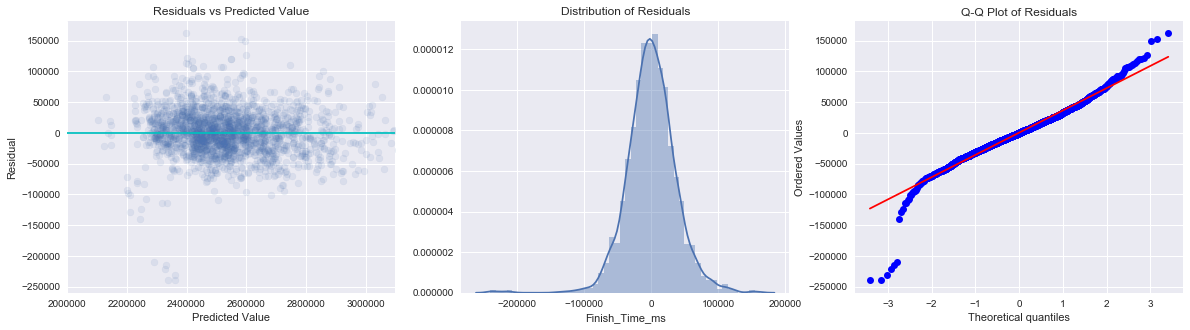

In [921]:
y_pred = lm.predict(interactions.fit_transform(x_ho))
res = y_ho - y_pred

plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Residuals vs Predicted Value')
plt.xlim(xmin=2000000, xmax=3100000)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.scatter(y_pred, res, alpha=.1);
plt.plot(np.linspace(0,3100000,1000),np.linspace(0,0,1000), color='c');

plt.subplot(1, 3, 2)
plt.title('Distribution of Residuals')
plt.xlabel('Error Value')
sns.distplot(res);

plt.subplot(1, 3, 3)
stats.probplot(res, plot=plt);
plt.title('Q-Q Plot of Residuals');

print('>> Mean of residuals: ',(res).mean())

A final look at the residual distributions and the Q-Q plot show similar distribution as before, with simple linear regression, but the more extreme error values have been reduced in magnitude. 

### Conclusion <a name='con'></a>  

> **Regression type:** Polynomial regression, degree 3, no regularization  
> **R<sup>2</sup>:** 0.95  
> **RMSE:** 37 seconds  

We were able to build a decent enough model by going through various options until finally arriving at a degree 3 polynomial regression that returned an R<sup>2</sup> value of 0.95 with the held-out test data. While that's a strong indicator, the RMSE value does leave something to be desired. At 36,908 milliseconds, it's equal to 37 seconds.  

To put that in context, at the final race of last season (2017 Valencia), the top 12 finishers out of 17 finished within 37 seconds of each other.  

For future development of this project, it will be very interesting to pull in laps/race data and try to predict laptimes instead of race finish times. That way, we can bring back the 10% of data we had ommitted due to races being cut short.